In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from PIL import Image
import os
import cv2
import torch
from torch.utils.data import Dataset

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Pytorch Version:[1.6.0]
device:[cuda:0]


In [36]:
class Cfg:
    data_dir = '../input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [5]:
df = pd.read_csv(os.path.join(Cfg.df_path))

In [7]:
df.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [11]:
len(df)

2700

In [18]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k : v for v, k in enumerate(num2class)}

In [34]:
def to_label(img_id, class_id):
    wear_mask = set(['mask1', 'mask2', 'mask3', 'mask4', 'mask5'])
    img_id = img_id.split("_")
    gender = img_id[1]
    age = int(img_id[-1])
    if (class_id in wear_mask) and (gender == "male"):
        if age < 30:
            return 0
        elif (age >= 30 and age < 60):
            return 1
        elif (age >= 60):
            return 2
    elif (class_id in wear_mask) and (gender == "female"):
        if age < 30:
            return 3
        elif (age >= 30 and age < 60):
            return 4
        elif (age >= 60):
            return 5
    elif (class_id == 'incorrect_mask') and (gender == "male"):
        if age < 30:
            return 6
        elif (age >= 30 and age < 60):
            return 7
        elif (age >= 60):
            return 8
    elif (class_id == 'incorrect_mask') and (gender == "female"):
        if age < 30:
            return 9
        elif (age >= 30 and age < 60):
            return 10
        elif (age >= 60):
            return 11
    elif (class_id == "normal") and (gender == "male"):
        if age < 30:
            return 12
        elif (age >= 30 and age < 60):
            return 13
        elif (age >= 60):
            return 14
    elif (class_id == "normal") and (gender == "female"):
        if age < 30:
            return 15
        elif (age >= 30 and age < 60):
            return 16
        elif (age >= 60):
            return 17

to_label("000001_female_Asian_45", "normal")

16

In [20]:
def get_extension(img_dir, img_id, class_id):
    """
    img_dir = Cfg.img_dir
    img_id = "000001_female_Asian_45" (example)
    class_id = mask1
    """
    filename = glob(os.path.join(img_dir, img_id, "*"))
    for f in filename:
        _class_id = f.split("/")[-1].split(".")[0]
        if class_id == _class_id:
            ext = os.path.splitext(f)[-1].lower()
            break
    return ext

In [38]:
class MaskDataset(Dataset):
    def __init__(self):
        self.df = pd.read_csv(os.path.join(Cfg.df_path))
        self.path = self.df.path
    
    def __getitem__(self, idx):
        directory, i = divmod(idx, 7)
        img_id = self.path[directory]
        class_id = num2class[i]
        ext = get_extension(Cfg.img_dir, img_id, class_id)
        path = os.path.join(Cfg.img_dir, img_id, class_id + ext)
        img = Image.open(path)
        img = np.array(img)
        label = to_label(img_id, class_id)
        return img, label

    def __len__(self):
        return len(self.df) * 7

In [40]:
test = MaskDataset()

In [46]:
img, label = test[0]

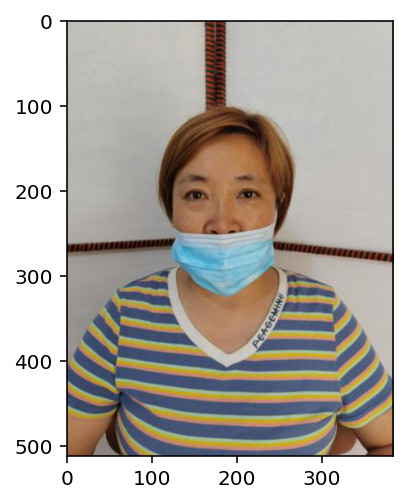

In [49]:
plt.imshow(img)

In [50]:
label

10

### target class 분포 확인해보기
- target class(18개)는 매우 불균형한 것으로 나타났다

In [115]:
from collections import defaultdict

class_count= defaultdict(int)
for i in range(len(df) * 7):
    directory, i = divmod(i, 7)
    img_id = df.path[directory]
    class_id = num2class[i]
    label = to_label(img_id, class_id)
    class_count[label] += 1

In [116]:
class_idx = []
class_counts = []
for i, x in class_count.items():
    class_idx.append(i)
    class_counts.append(x)
    
class_dict = dict(idx=class_idx, count=class_counts)

In [118]:
df_count = pd.DataFrame(class_dict)
df_count.head()

idx  count
0   10    817
1    4   4085
2   16    817
3    7    410
4    1   2050

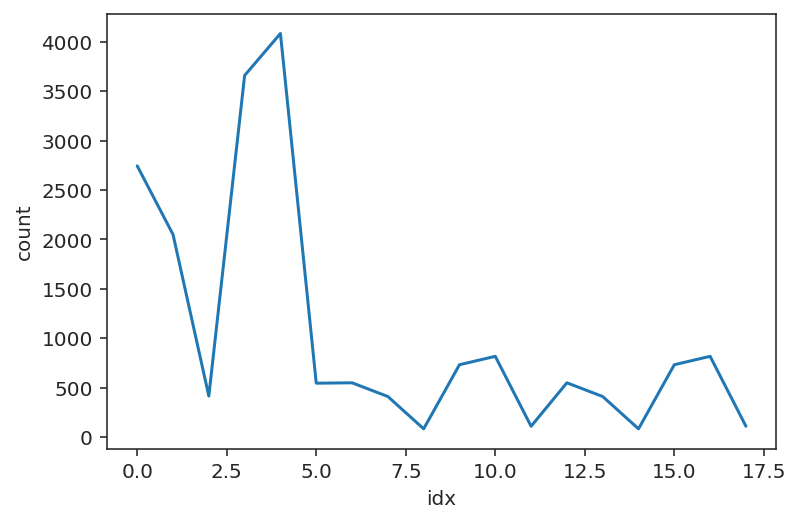

In [119]:
sns.lineplot(data=df_count, x="idx", y="count")  # x축 값을 알아서 정렬해준다. seaborn 볼수록 좋다.

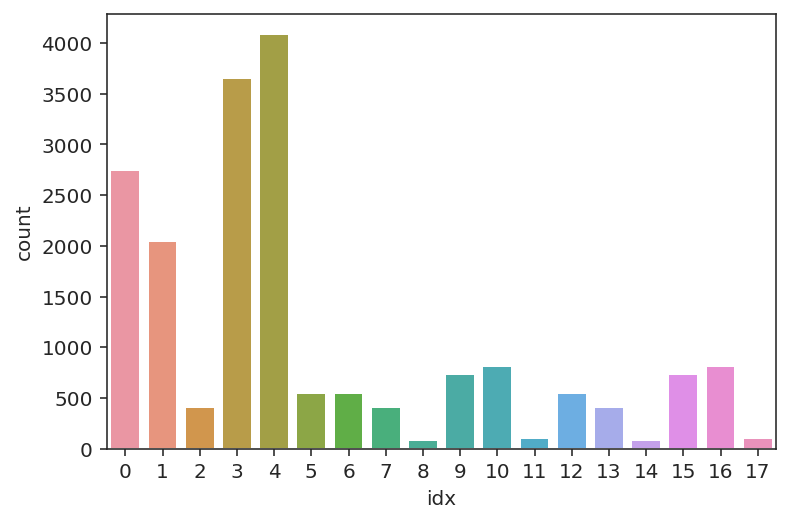

In [120]:
sns.barplot(data=df_count, x="idx", y="count")  # barplot - 평균

# baseline 참고 코드
### Image statistics

In [122]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [123]:
img_info = get_img_stats(Cfg.img_dir, df.path.values)

100%|██████████| 2700/2700 [09:27<00:00,  4.75it/s]


In [131]:
mean = np.mean(img_info["means"], axis=0) / 255.
std = np.mean(img_info["stds"], axis=0) / 255

In [132]:
mean, std

(array([0.56019358, 0.52410121, 0.501457  ]),
 array([0.23318603, 0.24300033, 0.24567522]))

### Augmentations
- Albumentation은 numpy 형식으로 이미지를 받아 데이터를 변형시킨다
- opencv 기반으로 빠르고, 다양한 Augmentation 방법이 제공된다

In [125]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

In [133]:
def get_transforms(need=('train', 'val'), img_size=(384, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    Args:
        need: 'train' 혹은 'val' 혹은 둘 다에 대한 augmentation 함수 얻을 건지에 대한 옵션
        img_size: augmentation 이후 얻을 이미지 사이즈
        mean: 이미지 normalize 할 때 사용될 RGB 평균값
        std: 이미지를 normalize 할 때 사용할 RGB 표준편차
    """
    
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=-0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    
    return transformations

In [134]:
class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2

class GenderLabels:
    male = 0
    female = 1
    
class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2

In [191]:
class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3
    
    _file_names = {
        "mask1": MaskLabels.mask,
        "mask2": MaskLabels.mask,
        "mask3": MaskLabels.mask,
        "mask4": MaskLabels.mask,
        "mask5": MaskLabels.mask,
        "incorrect_mask": MaskLabels.incorrect,
        "normal": MaskLabels.normal
    }
    
    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform
        
        self.setup()
    
    def set_transform(self, transform):
        self.transform = transform
    
    def setup(self):
        profiles = glob(os.path.join(self.img_dir, "*"))
        for profile in profiles:
            for file_name, label in self._file_names.items():
                ext = get_extension(self.img_dir, profile.split("/")[-1], file_name)
                img_path = os.path.join(profile, file_name + ext)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_labels.append(label)
                    
                    _, gender, race, age = profile.split("_")
                    # getattr : object의 속성값
                    # GenderLabels.male 과 같음
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)
                    
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label

        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label
    
    def __len__(self):
        return len(self.image_paths)

In [192]:
from torch.utils.data import random_split

transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(img_dir = Cfg.img_dir)

# train dataset과 val dataset을 나눈다
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정하자
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

### DataLoader
- Dataset 바탕으로 DataLoader 생성
- Dataset은 이미지 한장을 주는 모듈이면, DataLoader는 여러 이미지를 batch_size만큼 묶어서 전달

In [194]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

### Visualize Processed Data

In [196]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([12, 3, 384, 384])
labels shape: torch.Size([12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


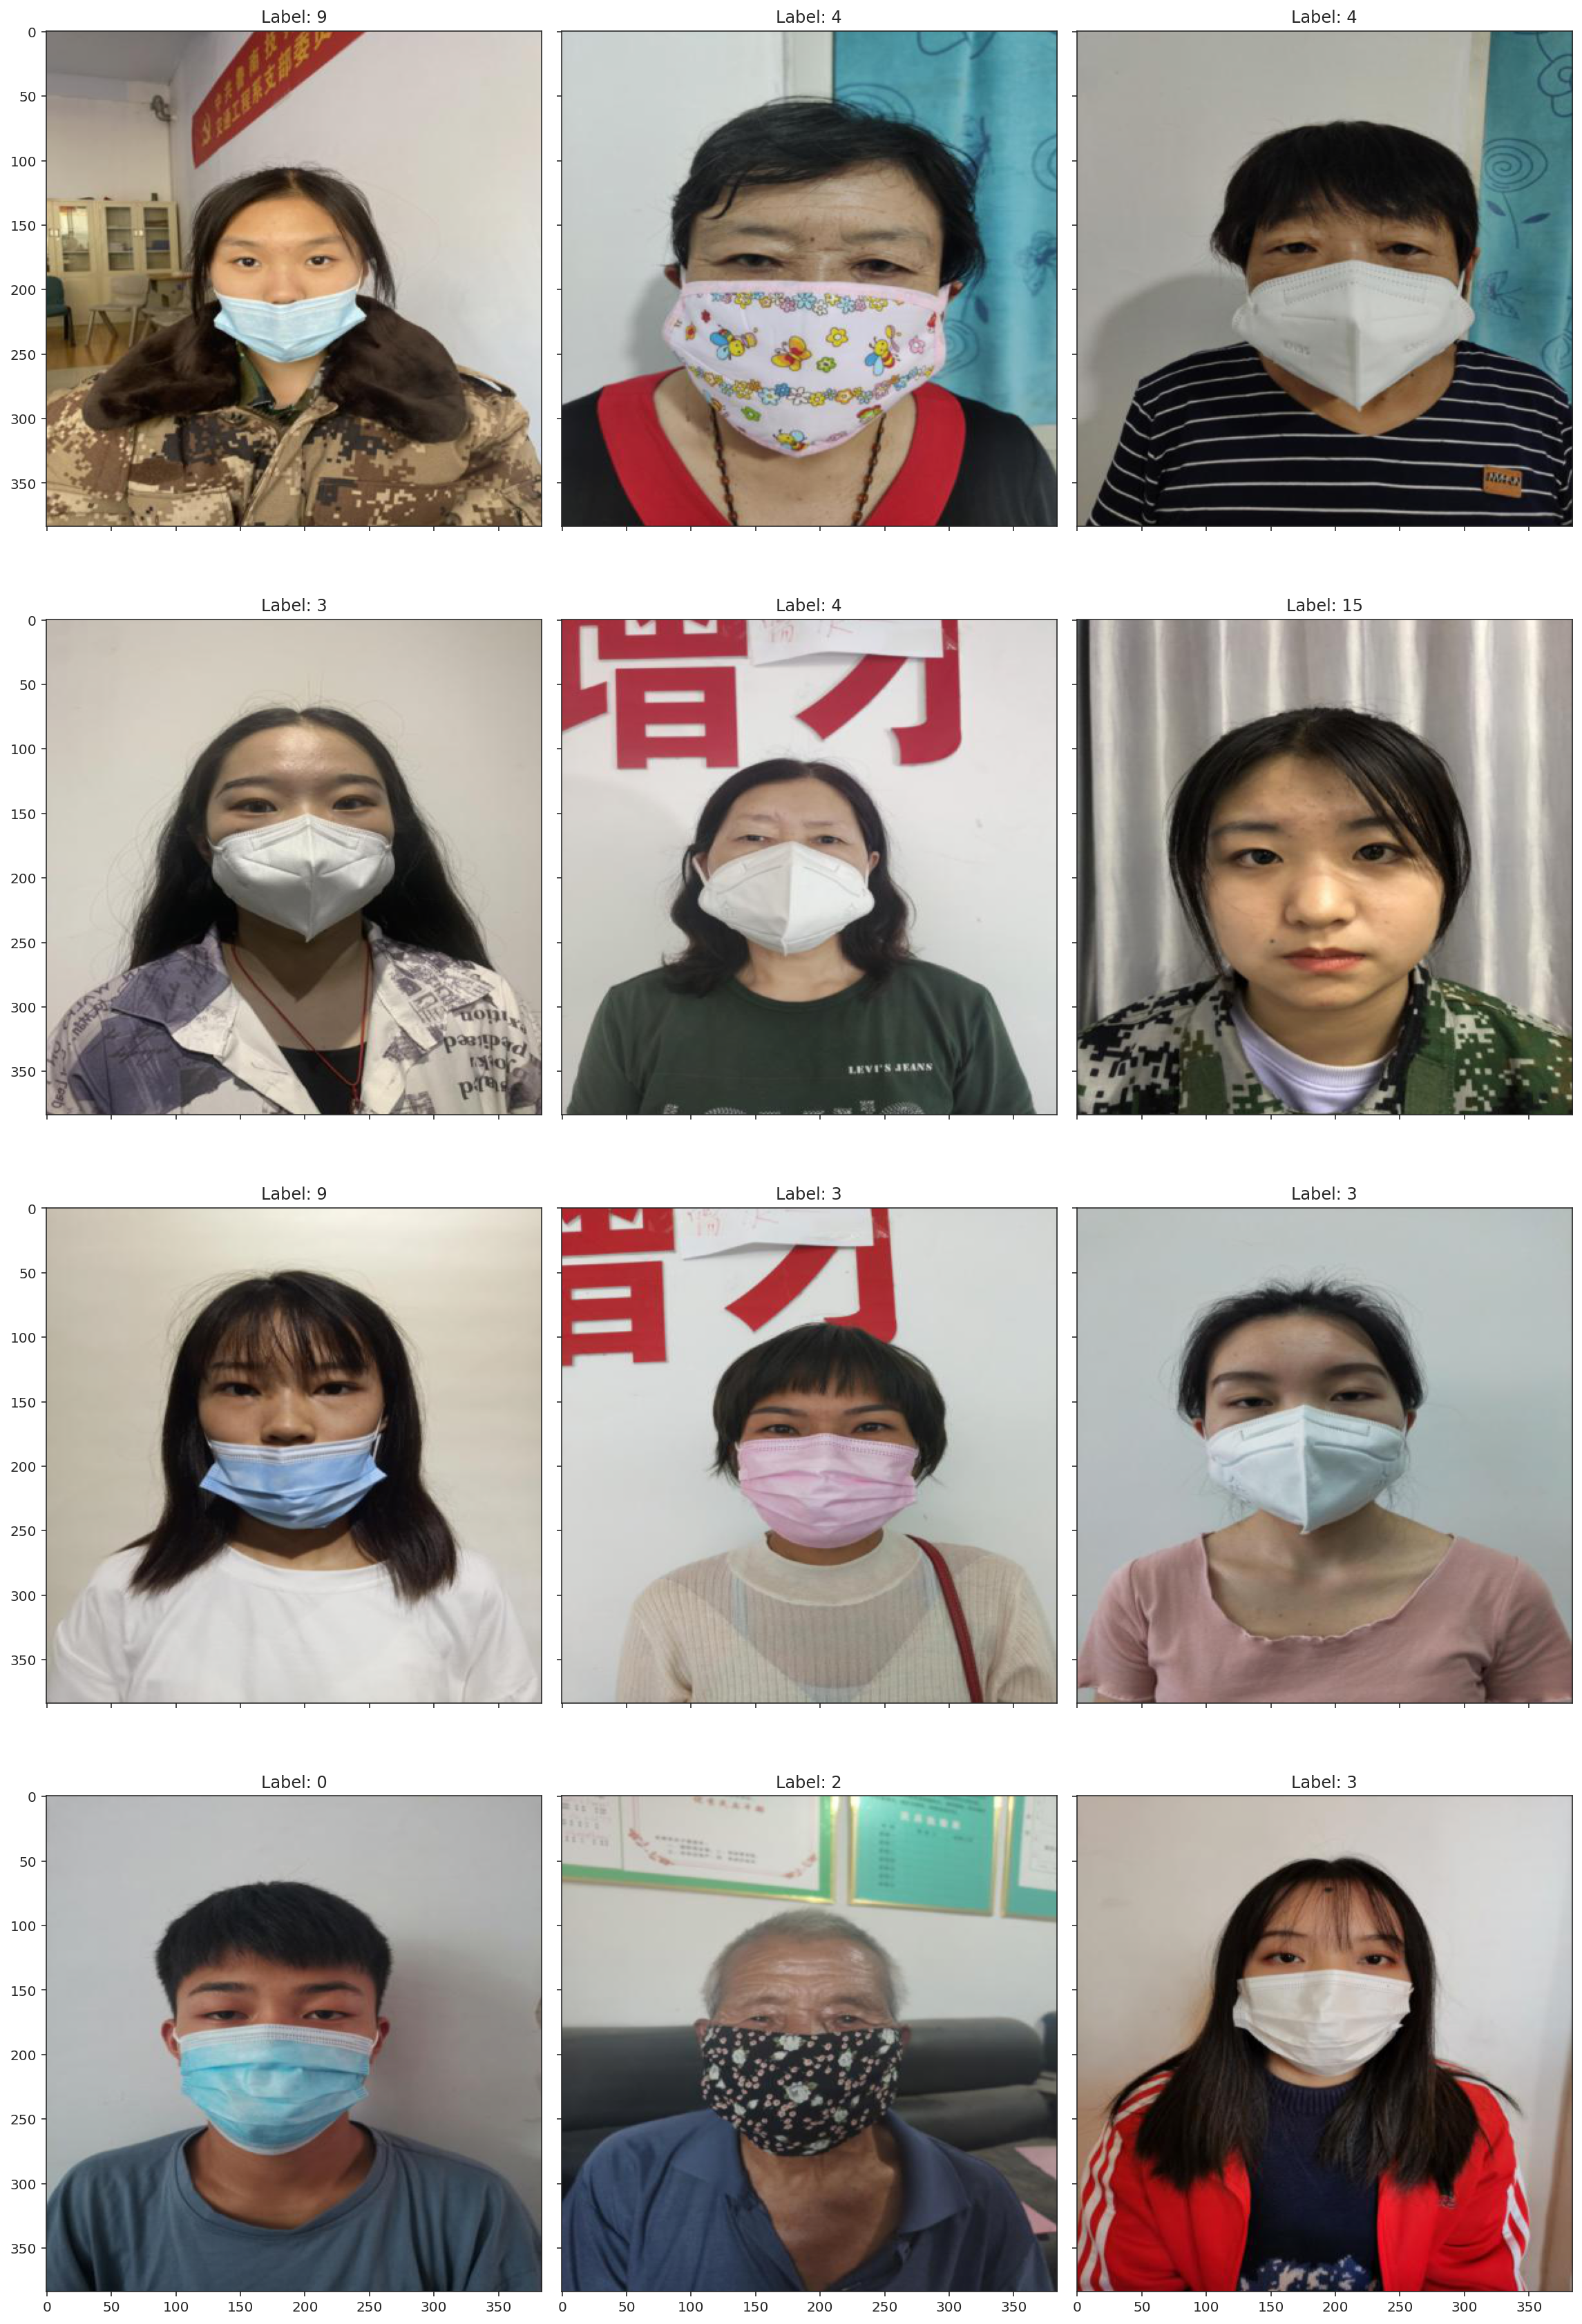

In [205]:
from torchvision import transforms

# augmentation으로 이미지를 normalize 했기 때문에, 역으로 다시 normalize 해줘야한다
inv_normalize = transforms.Normalize(
    mean = [-m / s for m, s in zip(mean, std)],
    std = [1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols + 1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols + 1)].set_title(f'Label: {labels[i]}')
    
plt.tight_layout()